# Lecture 26 : GPU Harmonic Sum

# Part 0 : Harmonic Series

### We learned in calculus that the harmonic series diverges to $\infty$.  
### $$S = \displaystyle\sum_{i=1}^{\infty} \frac{1}{i}$$
### In this lecture we will calculate the partial sum
### $$S = \displaystyle\sum_{i=1}^{N} \frac{1}{i}$$
### There is no exact formula for verifying our answers.
### We can use a sequential implementation to check our work.  

In [1]:
%%writefile harmonic.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

typedef unsigned long long int uint64;

int main(int argc, char **argv) {
    double term;
    double sum = 0;

    // get N from command line
    if (argc != 2) {
	printf ("Command usage : %s %s\n",argv[0],"N");
	return 1;
    }
    uint64 N = atoll(argv[1]);

    // start the timer
    clock_t start = clock();

    // calculate sum
    for (uint64 i = 1; i <= N; i++) {
	sum += 1.0/i;
    }

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // print results
    printf ("sum = %.10f\n",sum);
    printf ("elapsed time = %.2f seconds\n",elapsed);
}


Writing harmonic.c


In [3]:
!gcc -O3 -o harmonic harmonic.c

In [4]:
!./harmonic 1000000000

sum = 21.3004815023
elapsed time = 1.60 seconds


# Part 1 : A Single Thread Block
### Here is our first GPU version to compute $S$ that uses a single thread block.

In [14]:
%%writefile gpu_harmonic_v1.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    __shared__ double sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    // initialize sum to 0
    if (thread_num == 0) {
        sum = 0;
    }
    __syncthreads();

    // calculate the sum
    double thread_sum = 0;
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        thread_sum += 1.0/i;
    }
    atomicAdd(&sum,thread_sum);
    __syncthreads();

    // thread 0 prints the sum
    if (thread_num == 0) {
        printf ("sum = %.10f\n",sum);
    }

}

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }
    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    printf ("number of threads = %d\n",num_threads);

    // start the timer
    clock_t start = clock();

    // launch kernel
    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;
    printf ("elapsed time = %.2f seconds\n",elapsed);

}

Writing gpu_harmonic_v1.cu


In [15]:
!nvcc -arch=sm_75 -o gpu_harmonic_v1 gpu_harmonic_v1.cu

In [16]:
!./gpu_harmonic_v1 1000000000 256

number of threads = 256
sum = 21.3004815023
elapsed time = 2.72 seconds


### Discussion: What is the downside of using a single thread block?

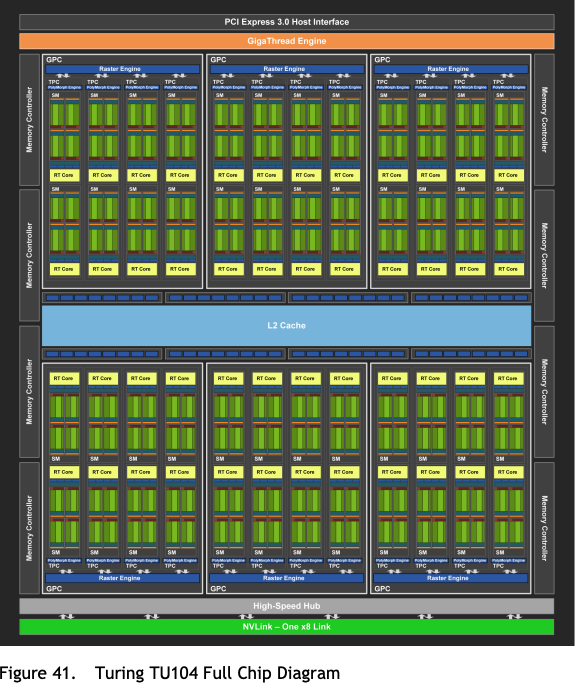

# Part 2 : Using the Full GPU (first attempt)

### Discussion: What is the minimal amount of work we can have each thread do?

### Answer:

### Here is a partially completed CUDA code for our first full GPU solution.  

### Complete the code in class.

In [11]:
%%writefile gpu_harmonic_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N, double* sum) {

    uint64 thread_num = (uint64)blockIdx.x*blockDim.x + threadIdx.x;
    if (thread_num < N) {
	    double term = 1.0/(thread_num+1);
	    atomicAdd(sum,term);
    }

}

int main (int argc, char** argv) {

    // get N and B from the command line
    // B is the number of threads per block
    // we typically choose B to be a multiple of 32
    // the maximum value of B is 1024
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    uint64 N = atoll(argv[1]);
    int B = atoi(argv[2]);

    // G is the number of thread blocks
    // the maximum number of thread blocks G is 2^31 - 1 = 2147483647
    // We choose G to be the minimum number of thread blocks to have at least N threads
    int G = (N+B-1)/B;
    printf ("N = %llu\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %llu\n",(uint64)G*B);

    // the computed sum in device memory
    double* d_sum;
    cudaMalloc (&d_sum,sizeof(double));

    // initialize the device harmonic sum to 0
    cudaMemset (d_sum,0,sizeof(double));

    // start the timer
    clock_t start = clock();

    // launch kernel
    sumKernel <<< G, B >>> (N,d_sum);

    // copy device sum from device to host
    double sum;
    cudaMemcpy (&sum, d_sum, sizeof(double),cudaMemcpyDeviceToHost);

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // output the results
    printf ("harmonic sum = %.10f\n",sum);
    printf ("elapsed time = %.2f seconds\n",elapsed);

    // free the memory on the device
    cudaFree (d_sum);

}


Writing gpu_harmonic_v2.cu


In [12]:
!nvcc -arch=sm_75 -o gpu_harmonic_v2 gpu_harmonic_v2.cu

In [13]:
!./gpu_harmonic_v2 1000000000 256

N = 1000000000
threads per block B = 256
number of thread blocks G = 3906250
number of threads G*B = 1000000000
harmonic sum = 21.3004815023
elapsed time = 2.10 seconds


### Discussion : Our first attempt at using the full GPU results in almost no speedup (recall the Millennium Falcon).  What is the primary problem of our first attempt?

# Part 3 : Using the Full GPU (second attempt)

### Discussion: How can we overcome the problems with our first attempt?

### Here is a partially completed CUDA code for our second full GPU solution.  

### Complete the code in class.  

### To let the GPU stretch its legs a bit we will have to crank $N$ to 100 billion for this version.

In [1]:
%%writefile gpu_harmonic_v3.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N, uint64 T, double* sum) {

    uint64 thread_num = (uint64)blockIdx.x*blockDim.x + threadIdx.x;
    double thread_sum = 0;
    uint64 start = thread_num*T;
    uint64 end = start+T;
    if (end > N) {
	    end = N;
    }
    for (uint64 i = start; i<end;i++) {
	    thread_sum += 1.0/(i+1);
    }
    atomicAdd(sum,thread_sum);
}

int main (int argc, char** argv) {

    // get N, T, and B from the command line
    // T is the number of terms per thread
    // B is the number of threads per block
    // we typically choose B to be a multiple of 32
    // the maximum value of B is 1024
    if (argc < 4) {
        printf ("Command usage : %s %s %s %s\n",argv[0],"N","T","B");
        return 1;
    }
    uint64 N = atoll(argv[1]);
    uint64 T = atoll(argv[2]);
    int B = atoi(argv[3]);

    // G is the number of thread blocks
    // the maximum number of thread blocks G is 2^31 - 1 = 2147483647
    // We choose G to be the minimum number of thread blocks to have
    // at least N/T threads
    int G = (N+B*T-1)/(B*T);
    printf ("N = %llu\n",N);
    printf ("terms per thread T = %llu\n",T);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %llu\n",(uint64)G*B);

    // the computed sum in device memory
    double* d_sum;
    cudaMalloc (&d_sum,sizeof(double));

    // initialize the device harmonic sum to 0
    cudaMemset (d_sum,0,sizeof(double));

    // start the timer
    clock_t start = clock();

    // launch kernel
    sumKernel <<< G, B >>> (N,T,d_sum);

    // copy device sum from device to host
    double sum;
    cudaMemcpy (&sum, d_sum, sizeof(double),cudaMemcpyDeviceToHost);

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // output the results
    printf ("sum = %.10f\n",sum);
    printf ("elapsed time = %.2f seconds\n",elapsed);

    // free the memory on the device
    cudaFree (d_sum);

}


Writing gpu_harmonic_v3.cu


In [2]:
!nvcc -arch=sm_75 -o gpu_harmonic_v3 gpu_harmonic_v3.cu

In [3]:
!./gpu_harmonic_v3 1000000000 1000 256

N = 1000000000
terms per thread T = 1000
threads per block B = 256
number of thread blocks G = 3907
number of threads G*B = 1000192
sum = 21.3004815023
elapsed time = 0.17 seconds


In [4]:
!./gpu_harmonic_v3 100000000000 1000 256

N = 100000000000
terms per thread T = 1000
threads per block B = 256
number of thread blocks G = 390625
number of threads G*B = 100000000
sum = 25.9056516878
elapsed time = 4.45 seconds


# Class Exercise: The standard deviation of the numbers $1 ... N$ is given by
$$\sigma = \sqrt{\frac{N^2-1}{12}}$$

A sequential code to compute the standard deviation of the numbers
$1 ... N$ is given below.  

Begin to write an efficient CUDA implementation that uses the techniques developed in this lecture.   

Hint: You will need to use two separate CUDA kernels!

In [13]:
%%writefile std_dev.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

typedef unsigned long long int uint64;

int main (int argc, char** argv) {

    /* get N from the command line */
    if (argc < 2) {
        printf ("Command usage : %s %s\n",argv[0],"N");
        return 1;
    }
    uint64 N = atol(argv[1]);

    /* compute the mean */
    uint64 sum = 0;
    for (uint64 i=1;i<=N;i++) {
        sum += i;
    }
    double mean = 1.0*sum/N;

    /* compute the variance */
    double sum_diff_sq = 0;
    for (uint64 i=1;i<=N;i++) {
        sum_diff_sq += (i-mean)*(i-mean);
    }
    double variance = sum_diff_sq/N;

    /* compute the standard deviation */
    double std_dev = sqrt(variance);

    /* print the results */
    printf ("computed std dev is %.1lf, sqrt((N^2-1)/12) is %.1lf\n",std_dev,sqrt((N*N-1)/12.0));

}


Writing std_dev.c


In [14]:
!gcc -o std_dev std_dev.c -lm

In [15]:
!time ./std_dev 100000000

computed std dev is 28867513.5, sqrt((N^2-1)/12) is 28867513.5

real	0m0.583s
user	0m0.582s
sys	0m0.001s
